In [62]:
import os
import random
from glob import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.io import read_image
import torchvision.transforms.functional as func

In [63]:
def add_gaussian_noise(image_tensor: torch.Tensor, mean=0.0, std=0.01) -> torch.Tensor:
    """
    Adds gaussian noise to an image tensor.
    """
    noise = torch.randn_like(image_tensor) * std + mean
    noisy_image = image_tensor + noise
    return torch.clamp(noisy_image, 0.0, 1.0)


def get_rotated_images(image_tensor: torch.Tensor) -> list[torch.Tensor]:
    """
    Returns a list of 4 tensors which represent the image rotated by 0, 90, 180 and 270 degrees.
    """
    rotated_images = []
    for angle in [90, 180, 270]:
        rotated_images.append(func.rotate(image_tensor, angle))

    return rotated_images


def adjust_contrast_tensor(image_tensor: torch.Tensor, factor=1.5) -> torch.Tensor:
    """
    Adjust the contrast of a grayscale image tensor.

    Args:
        image_tensor (torch.Tensor): Tensor of shape (1, H, W) or (B, 1, H, W) with values in [0, 1].
        factor (float): Contrast adjustment factor. >1 increases contrast, <1 decreases.

    Returns:
        torch.Tensor: Contrast-adjusted image tensor.
    """
    mean = image_tensor.mean(dim=(-2, -1), keepdim=True)
    adjusted = (image_tensor - mean) * factor + mean
    return torch.clamp(adjusted, 0.0, 1.0)


def apply_affine_transform(image_tensor,
                           max_rotation=15,
                           max_translation=0.05,
                           scale_range=(0.95, 1.05),
                           max_shear=5):
    """
    Apply a small random affine transformation to a grayscale image tensor.

    Args:
        image_tensor (torch.Tensor): Tensor of shape (1, H, W) with values in [0, 1]
        max_rotation (float): Max degrees for rotation (±)
        max_translation (float): Max proportion of width/height to translate
        scale_range (tuple): Min and max scale factors
        max_shear (float): Max shear angle in degrees (±)

    Returns:
        torch.Tensor: Transformed image tensor (1, H, W)
    """
    _, h, w = image_tensor.shape

    angle = random.uniform(-max_rotation, max_rotation)
    translate_x = int(max_translation * w * random.uniform(-1, 1))
    translate_y = int(max_translation * h * random.uniform(-1, 1))
    scale = random.uniform(*scale_range)
    shear = random.uniform(-max_shear, max_shear)

    transformed = func.affine(
        image_tensor,
        angle=angle,
        translate=[translate_x, translate_y],
        scale=scale,
        shear=shear,
        interpolation=func.InterpolationMode.BILINEAR,
        fill=0.75
    )

    return transformed


def get_augmented_images(image_tensor: torch.Tensor, augmentation="low") -> list[torch.Tensor]:
    augmented_images = [image_tensor]
    augmented_images.extend(get_rotated_images(image_tensor))

    if augmentation == "low":
        return augmented_images

    contrasted = [adjust_contrast_tensor(i) for i in augmented_images]
    augmented_images.extend(contrasted)

    if augmentation == "medium":
        return augmented_images

    noisy = [add_gaussian_noise(i) for i in augmented_images]
    augmented_images.extend(noisy)

    transformed = [apply_affine_transform(i) for i in augmented_images]
    return augmented_images + transformed


In [73]:
class SkinCancerDataset(Dataset):
    def __init__(self, transform, path):
        self.samples = []

        for file_path in glob(os.path.join(path, "*.jpg")):
            file_name = os.path.basename(file_path)
            class_id = int(file_name.split("_")[0]) - 1

            image = read_image(file_path)
            image = transform(image).float() / 255.0

            if class_id in [3, 5]:  # 1 image -> 4 images
                images = get_augmented_images(image, augmentation="low")
            elif class_id in [1, 2]:  # 1 image -> 8 images
                images = get_augmented_images(image, augmentation="medium")
            elif class_id in [4, 7]:  # 1 image -> 32 images
                images = get_augmented_images(image, augmentation="high")
            else:
                images = [image]

            for i in images:
                self.samples.append((i, class_id))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        tensor, label = self.samples[idx]
        return tensor, label


In [74]:
folder_path = "train"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
])

train_set = SkinCancerDataset(transform, folder_path)
print(len(train_set))
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

20607


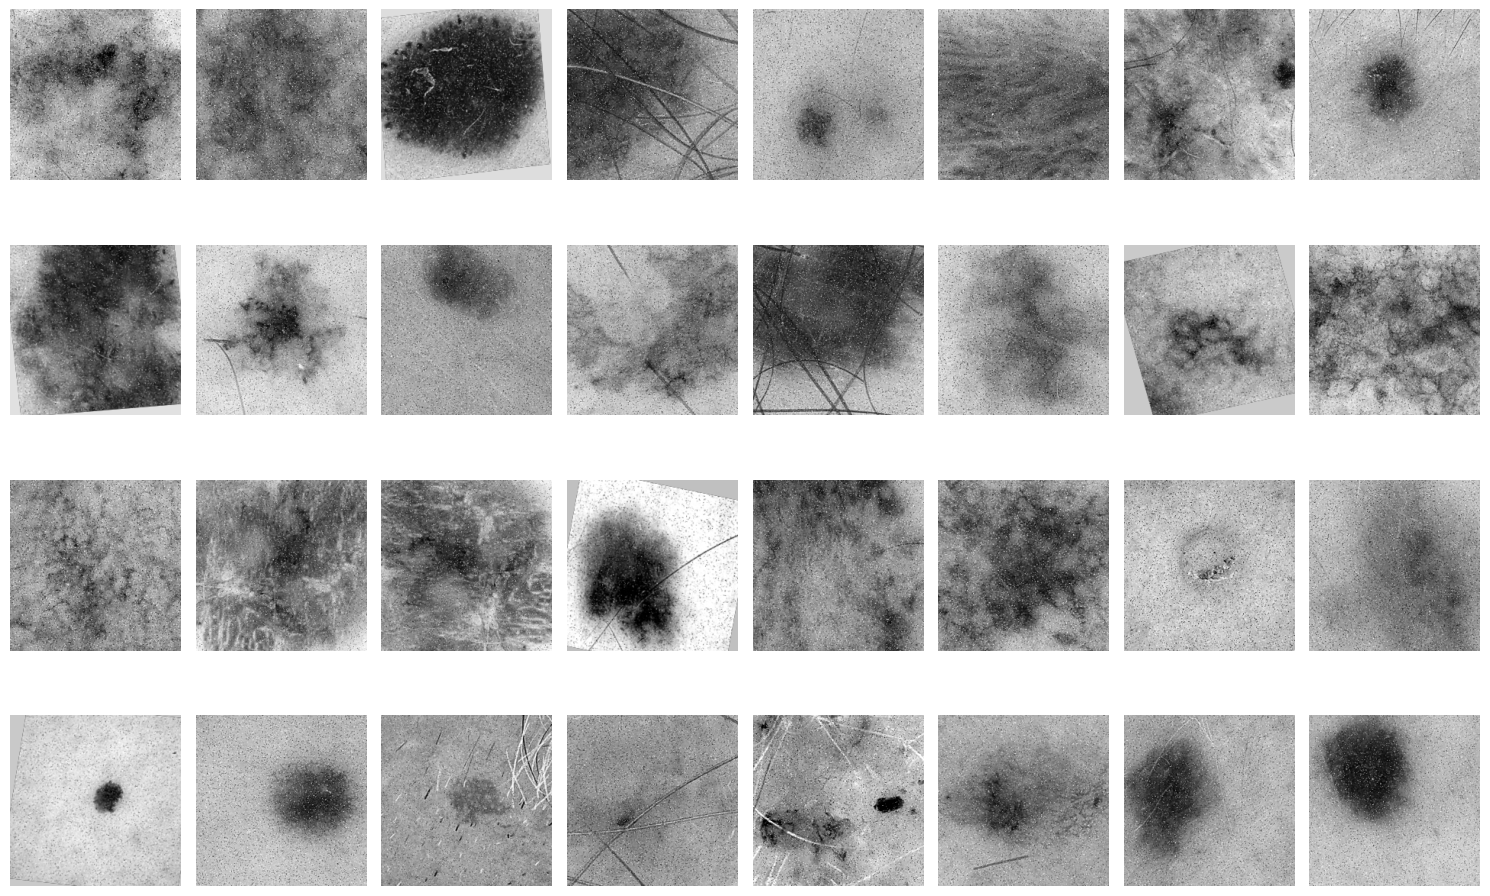

In [75]:
import matplotlib.pyplot as plt

images, _ = next(iter(train_loader))

if images is not None:
    images = images.view(32, 224, 224).detach().numpy()

    rows = (len(images) + 8 - 1) // 8
    plt.figure(figsize=(15, 10))
    for i, img in enumerate(images):
        plt.subplot(rows, 8, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [81]:
# Depth-wise separable conv block
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3,
                                   stride=stride, padding=1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                                   stride=1, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.relu(x)


class MobileNetV1Gray(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False),  # for grayscale
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            DepthwiseSeparableConv(32, 64),
            DepthwiseSeparableConv(64, 128, stride=2),
            DepthwiseSeparableConv(128, 256, stride=2),
            DepthwiseSeparableConv(256, 512, stride=2),

            *[DepthwiseSeparableConv(512, 512) for _ in range(3)],

            DepthwiseSeparableConv(512, 1024, stride=2),
            DepthwiseSeparableConv(1024, 1024),

            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNetV1Gray(num_classes=7).to(device)
print(model)

MobileNetV1Gray(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): DepthwiseSeparableConv(
      (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (4): DepthwiseSeparableConv(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (5): DepthwiseSeparableConv(
      (depthwise

In [92]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
num_epochs = 25

In [93]:
from tqdm import tqdm

losses = []
for epoch in range(num_epochs):
    epoch_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        running_loss = epoch_loss / len(train_loader)
        loop.set_postfix(running_loss=running_loss)

    losses.append(epoch_loss / len(train_loader))
    scheduler.step()


Epoch 25/25: 100%|██████████| 644/644 [00:47<00:00, 13.68it/s, running_loss=0.00541]


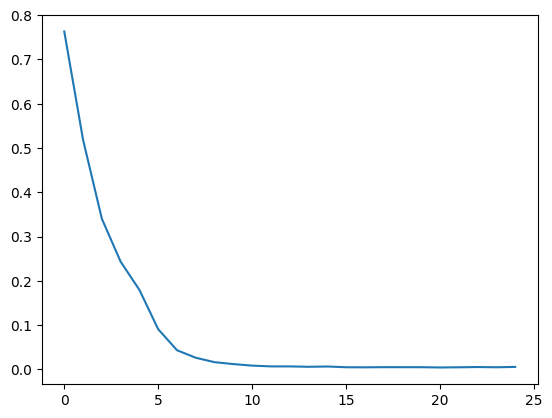

In [94]:
plt.plot(losses)
plt.show()

In [95]:
val_set = SkinCancerDataset(transform, "val")
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

model.eval()
with torch.no_grad():
    correct = 0
    total = 0

    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += torch.eq(predicted, labels).sum().item()

    print(f"Accuracy: {100 * correct / total}")

Accuracy: 65.16120066703725


In [96]:
torch.save(model.state_dict(), "model_1.pth")